# Second order stochastic methods for CryoEM -- OASIS

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops, get_cg_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.algorithm import oasis, oasis_adaptive
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [3]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles: 105519
load_data: data loaded, time:  77.54 sec.


In [4]:
out_dir = out_dir = '../data/out_dev/'

In [5]:
nx0 = imgs0.shape[1]
nx_crop = 64 #128 # 64
N = 20000 #80000 # 20000
N_px_noise = 48
N_imgs_noise=1000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop, N = N, N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

imgs0.shape = (105519, 320, 320)
pixel_size0.shape = (105519,)
angles0.shape = (105519, 3)
shifts0.shape = (105519, 2)
ctf_params0.shape = (105519, 9)
Shuffle = False
N = 20000
Taking FFT of the images:
Batch 1/10  5.48 sec.
Batch 2/10  5.47 sec.
Batch 3/10  5.48 sec.
Batch 4/10  5.48 sec.
Batch 5/10  5.48 sec.
Batch 6/10  5.48 sec.
Batch 7/10  5.48 sec.
Batch 8/10  5.47 sec.
Batch 9/10  5.48 sec.
Batch 10/10  5.48 sec.
FFT done. Time:  67.88 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 6.40000000e+01]
Vectorised imgs_f.shape = (20000, 4096)
Mask radius = 0.0739503816793893
Estimating the noise using the 48 x 48 corners of the first 1000 images.
Estimating pixel-wise noise...done.
Averaging radially...done.
Noise estimation done. Time:  10.37 sec.


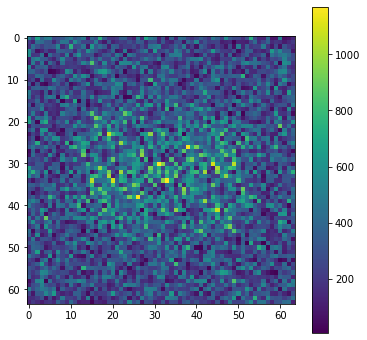

In [6]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[135].reshape([nx_crop,nx_crop]))));plt.colorbar()

In [7]:
#del(imgs0)

### Only volume reconstruction for now - SGD vs OASIS

In [8]:
sigma_noise_est = sigma_noise
sigma_noise = jnp.ones(sigma_noise.shape)
#sigma_noise = sigma_noise_est

In [9]:
sigma_noise

DeviceArray([1., 1., 1., ..., 1., 1., 1.], dtype=float64)

In [10]:
jnp.max(sigma_noise_est)/jnp.min(sigma_noise_est)

DeviceArray(2.1237166, dtype=float64)

In [11]:
# Apply mask to images
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [12]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [93]:
mask0 = jnp.ones(mask.shape)

In [276]:
alpha =  1e-9 #1e-5 #1e-9 #1e-9 # 1e-5

slice_obj = Slice(x_grid, mask = mask, interp_method="nn")
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

Use the same datasets, loss, grad, hvp, x0, D0 for SGD, OASIS (and CG)

In [277]:
idxrand = np.random.permutation(N)
idx1 = idxrand[:N//2]
idx2 = idxrand[N//2:]

In [278]:
grad_func1, loss_func1, hvp_func1 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], sigma_noise)
grad_func2, loss_func2, hvp_func2 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], sigma_noise)

# No CTF for now
#no_ctf_params = np.zeros(N)
#no_shifts = np.zeros(shifts.shape)

#grad_func1, loss_func1, hvp_func1 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx1], shifts[idx1], no_ctf_params[idx1], imgs_f[idx1], sigma_noise)
#grad_func2, loss_func2, hvp_func2 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx2], shifts[idx2], no_ctf_params[idx2], imgs_f[idx2], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)


In [283]:
n_epochs = 20 #2000 * 4 
batch_sz = 100
n_batch = N//2 / batch_sz

zD01z = np.zeros([nx,nx,nx])
zD02z = np.zeros([nx,nx,nx])

for i in tqdm(range(n_epochs)):
    key, subkey = random.split(key)
    idx_batches = np.array_split(random.permutation(subkey, N//2), n_batch)
    
    for idx in idx_batches:
        key, subkey = random.split(key)
   
        z = random.rademacher(subkey, [nx,nx,nx], dtype=x0.dtype)
        #z = random.rademacher(subkey, [nx,nx,nx])
    
        zD01z += z * hvp_func1(x0, z, idx)
        zD02z += z * hvp_func2(x0, z, idx)
    
D01 = jnp.array(zD01z/(n_epochs * n_batch))
D02 = jnp.array(zD02z/(n_epochs * n_batch))

100%|██████████| 20/20 [03:15<00:00,  9.76s/it]


1.0000000000000342e-09
0.09693517822331879
96935178.22331548


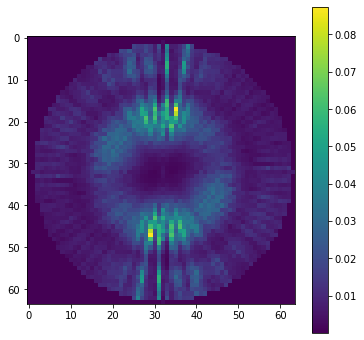

In [284]:
plt.imshow(jnp.fft.fftshift(jnp.abs(D01[0,:,:]))); plt.colorbar()
print(jnp.min(jnp.abs(D01)))
print(jnp.max(jnp.abs(D01)))
print(jnp.max(jnp.abs(D01))/jnp.min(jnp.abs(D01)))

1.0000000000000342e-09
0.09693517822331879


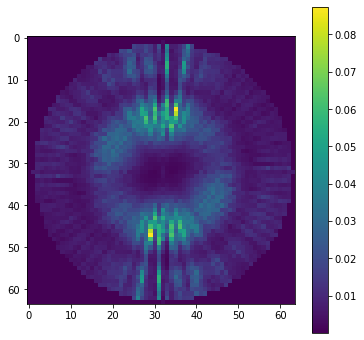

In [285]:
DD = jnp.maximum(jnp.abs(D01), 1e-9)
plt.imshow(jnp.fft.fftshift(jnp.abs(DD[0,:,:]))); plt.colorbar()
print(jnp.min(jnp.abs(DD)))
print(jnp.max(jnp.abs(DD)))

In [286]:
print(jnp.max(jnp.abs(D01)))
print(jnp.max(jnp.abs(D02)))
print(jnp.max(jnp.abs(D01-D02)))

0.09693517822331879
0.09643950422159928
0.012915120934451678


In [290]:
# Compute the Hessian diagonals exactly (valid for NN interpolation) - do it in batches

batch_sz = 100
n_batch = N//2 / batch_sz
idx_batches = np.array_split(np.arange(N//2), n_batch)
ones = jnp.ones(x0.shape, dtype=jnp.complex128)

D1 = np.zeros([nx,nx,nx], dtype=np.complex128)
D2 = np.zeros([nx,nx,nx], dtype=np.complex128)
for idx in idx_batches:
    D1 += hvp_func1(x0, ones, idx)
    D2 += hvp_func2(x0, ones, idx)    
    
D1 = jnp.array(D1/n_batch)
D2 = jnp.array(D2/n_batch)


9.999999999999988e-10
0.09693517822331874
96935178.22331885


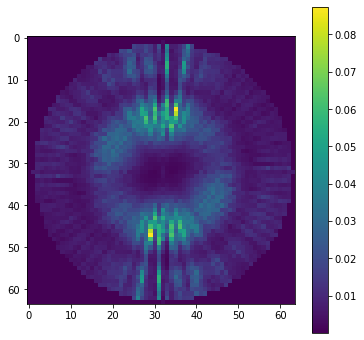

In [292]:
plt.imshow(jnp.fft.fftshift(jnp.abs(D1[0,:,:]))); plt.colorbar()
print(jnp.min(jnp.abs(D1)))
print(jnp.max(jnp.abs(D1)))
print(jnp.max(jnp.abs(D1))/jnp.min(jnp.abs(D1)))

In [298]:
err = jnp.max(jnp.abs(D1-D01)/jnp.max(jnp.abs(D1)))
print(f"Error = {err}")

Error = 2.4338160516848595e-15


#### Sanity check that the Hessian is indeed diagonal for NN interpolation and that I'm computing it correctly

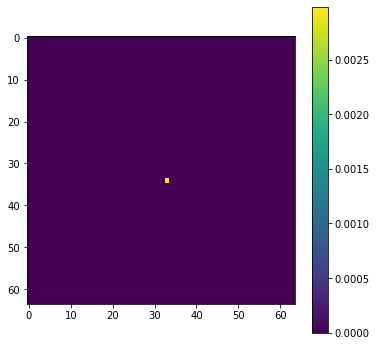

In [279]:
ei = jnp.zeros([nx,nx,nx], dtype = jnp.complex128)
ei = ei.at[0,2,1].set(1)
hvp = hvp_func1(x0, ei, [4123, 1, 0, 6])
plt.imshow(jnp.fft.fftshift(jnp.abs(hvp[0,:,:]))); plt.colorbar()

In [280]:
jnp.abs(hvp[0,2,1] - jnp.sum(hvp))

DeviceArray(0., dtype=float64)

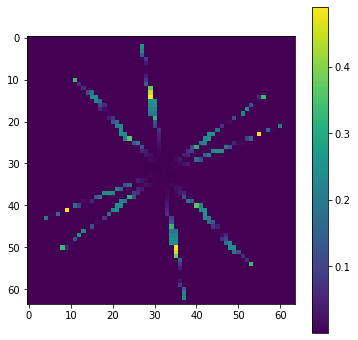

In [281]:
ones = jnp.ones(x0.shape, dtype=jnp.complex128)
hvp_diag = hvp_func1(x0, ones, [4123, 1, 0, 6])
plt.imshow(jnp.fft.fftshift(jnp.abs(hvp_diag[0,:,:]))); plt.colorbar()

In [282]:
jnp.abs(hvp[0,2,1] - hvp_diag[0,2,1])

DeviceArray(0., dtype=float64)

#### SGD

In [299]:
key, subkey1, subkey2 = random.split(key, 3)
x01 = random.normal(subkey1, [nx,nx,nx], dtype = jnp.complex128)
x02 = random.normal(subkey2, [nx,nx,nx], dtype = jnp.complex128)


In [308]:
N_epochs = 10
batch_size = 1000
step_size =  1e1 #1e1 #1e-4 #1e-1 #1e-5 #1e-2 #1000000 # 1e-3

# Step sizes (empirically found, i.e. the largest that doesn't lead to loss exploding): 

# 10k imgs, 64px:
#   no sigma_noise, no precon: 1e1 V
#   no sigma_noise, with precon: 1e-1 V
#   with sigma_noise, no precon: 1e6 V
#   with sigma_noise, with precon: 1e-1 V

# 40k imgs, 128px , reg 1e-8
#  no sigma_noise, no precon: 1e1 V
#  no sigma_noise, with precon: 1e-1 

# ---

#  with sigma_noise, no precon: 1e5
#  with_sigma_noise, with precon: 1e-3

#### NN interpolation, no sigma_noise, lam=1e-9

# 10k imgs, 64px:
#   no precon: 1e1
#   precon: 1e-1

# 40k imgs, 128px:
#  no precon: 1e1
#  precon: 1e-2


In [309]:
P1 = None
#P1 = 1/D01

v_rec1, loss_rec1, grad_rec1 = sgd(grad_func1, loss_func1, N//2, x01, step_size, N_epochs, batch_size, P = P1, verbose=True, iter_display=1)


Epoch 1/10 

100%|██████████| 10/10 [00:18<00:00,  1.85s/it, grad=1.833e+01, loss=3.220e+08]


  |Grad| = 2.205e+01
  Loss = 3.233e+08
Epoch 2/10 

100%|██████████| 10/10 [00:19<00:00,  1.92s/it, grad=2.451e+01, loss=3.206e+08]


  |Grad| = 1.733e+01
  Loss = 3.218e+08
Epoch 3/10 

100%|██████████| 10/10 [00:19<00:00,  1.90s/it, grad=1.494e+01, loss=3.204e+08]


  |Grad| = 1.799e+01
  Loss = 3.211e+08
Epoch 4/10 

100%|██████████| 10/10 [00:19<00:00,  1.91s/it, grad=1.639e+01, loss=3.211e+08]


  |Grad| = 1.657e+01
  Loss = 3.208e+08
Epoch 5/10 

100%|██████████| 10/10 [00:19<00:00,  1.91s/it, grad=1.822e+01, loss=3.227e+08]


  |Grad| = 1.755e+01
  Loss = 3.207e+08
Epoch 6/10 

100%|██████████| 10/10 [00:19<00:00,  1.91s/it, grad=1.634e+01, loss=3.176e+08]


  |Grad| = 1.682e+01
  Loss = 3.206e+08
Epoch 7/10 

100%|██████████| 10/10 [00:19<00:00,  1.92s/it, grad=2.104e+01, loss=3.215e+08]


  |Grad| = 1.795e+01
  Loss = 3.205e+08
Epoch 8/10 

100%|██████████| 10/10 [00:19<00:00,  1.91s/it, grad=1.485e+01, loss=3.165e+08]


  |Grad| = 1.667e+01
  Loss = 3.205e+08
Epoch 9/10 

100%|██████████| 10/10 [00:19<00:00,  1.91s/it, grad=2.368e+01, loss=3.178e+08]


  |Grad| = 1.694e+01
  Loss = 3.204e+08
Epoch 10/10 

100%|██████████| 10/10 [00:19<00:00,  1.91s/it, grad=1.696e+01, loss=3.194e+08]


  |Grad| = 1.712e+01
  Loss = 3.204e+08


In [313]:
P2 = None
#P2 = 1/D02

v_rec2, loss_rec2, grad_rec2 = sgd(grad_func2, loss_func2, N//2, x02, step_size, N_epochs, batch_size, P = P2, verbose=True, iter_display=1)


Epoch 1/10 

100%|██████████| 10/10 [00:18<00:00,  1.85s/it, grad=1.760e+01, loss=3.218e+08]


  |Grad| = 2.202e+01
  Loss = 3.228e+08
Epoch 2/10 

100%|██████████| 10/10 [00:19<00:00,  1.91s/it, grad=1.469e+01, loss=3.180e+08]


  |Grad| = 1.646e+01
  Loss = 3.213e+08
Epoch 3/10 

100%|██████████| 10/10 [00:19<00:00,  1.91s/it, grad=1.593e+01, loss=3.178e+08]


  |Grad| = 1.766e+01
  Loss = 3.207e+08
Epoch 4/10 

100%|██████████| 10/10 [00:19<00:00,  1.93s/it, grad=1.491e+01, loss=3.144e+08]


  |Grad| = 1.607e+01
  Loss = 3.204e+08
Epoch 5/10 

100%|██████████| 10/10 [00:19<00:00,  1.91s/it, grad=1.417e+01, loss=3.146e+08]


  |Grad| = 1.536e+01
  Loss = 3.202e+08
Epoch 6/10 

100%|██████████| 10/10 [00:19<00:00,  1.91s/it, grad=1.941e+01, loss=3.175e+08]


  |Grad| = 1.726e+01
  Loss = 3.201e+08
Epoch 7/10 

100%|██████████| 10/10 [00:19<00:00,  1.92s/it, grad=1.625e+01, loss=3.190e+08]


  |Grad| = 1.798e+01
  Loss = 3.200e+08
Epoch 8/10 

100%|██████████| 10/10 [00:19<00:00,  1.91s/it, grad=1.586e+01, loss=3.206e+08]


  |Grad| = 1.661e+01
  Loss = 3.200e+08
Epoch 9/10 

100%|██████████| 10/10 [00:19<00:00,  1.92s/it, grad=1.876e+01, loss=3.172e+08]


  |Grad| = 1.637e+01
  Loss = 3.200e+08
Epoch 10/10 

100%|██████████| 10/10 [00:19<00:00,  1.91s/it, grad=1.713e+01, loss=3.146e+08]


  |Grad| = 1.690e+01
  Loss = 3.199e+08


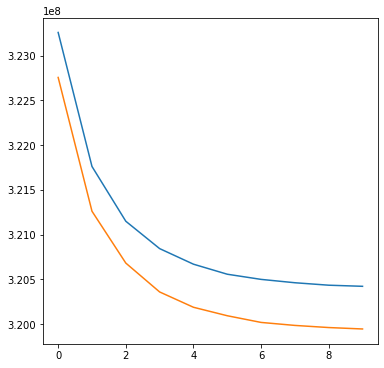

In [314]:
plt.plot(loss_rec1)
plt.plot(loss_rec2)

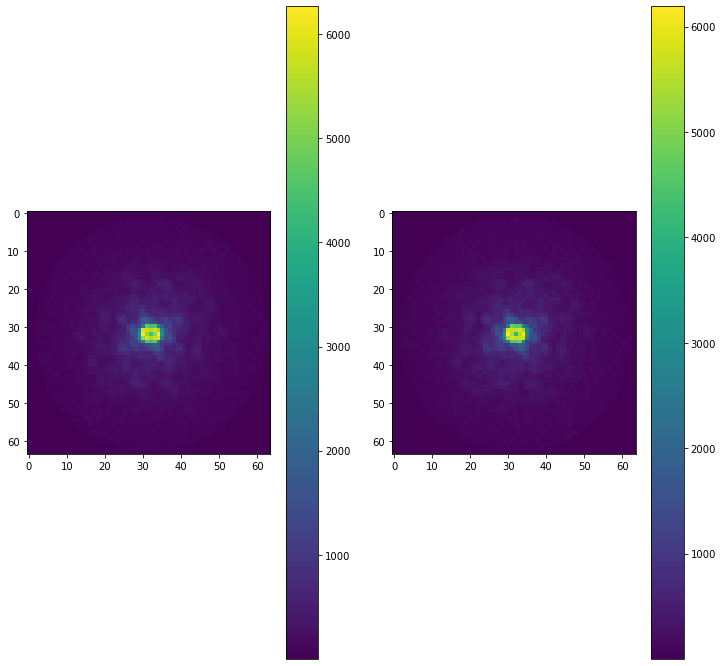

In [315]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec2))); plt.colorbar()

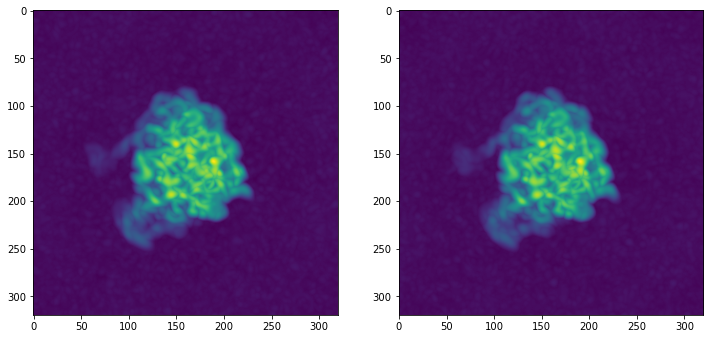

In [316]:
v_rec_l1, _ = rescale_larger_grid(v_rec1, x_grid, nx0)
vr_sgd1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l1)))

v_rec_l2, _ = rescale_larger_grid(v_rec2, x_grid, nx0)
vr_sgd2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l2)))

plt.subplot(1,2,1)
mip_z(vr_sgd1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_sgd2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [317]:
with mrcfile.new(f"{out_dir}/v_rec_sgd1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_sgd2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd2.astype(np.float32))   

Text(0.5, 1.0, 'FSC')

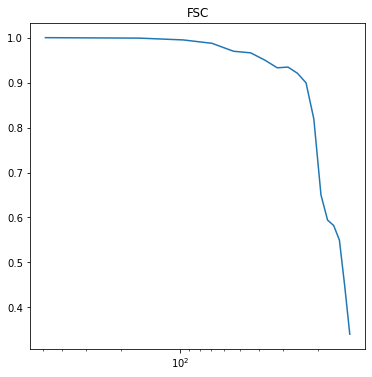

In [318]:
res, fsc_sgd, shell_points = calc_fsc(v_rec1, v_rec2, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_sgd)
plt.gca().invert_xaxis()
plt.title("FSC")

In [319]:
print(fsc_sgd[15])
print(fsc_sgd[16])
print(res_angs[15])
print(res_angs[16])

0.5498520311256022
0.44707411504967215
15.614531151244588
14.668195929957037


#### OASIS

In [326]:
N_epoch = 10 #30
beta2 = 1 #0.99
eta0 = 1e-1 #1e-2 # 1e-3 #1e-5 #0.0001 #0.1/0.001/0.01/0.15
batch_size = 1000
alpha = 0 #1e-7 

D0bad = jnp.array(np.random.randn(*D01.shape))

key, subkey = random.split(key)


# Step sizes (eta0): 
#
# 10k imgs, 64px:
#   no sigma_noise: 1e-2 V
#   with sigma_noise: 1e-1 V
#
# 40k imgs, 128px:
#   no sigma_noise: 1e-3
#   with sigma_noise: 1e-2


#### NN interpolation, no sigma_noise, lam=1e-9

# 10k imgs, 64px:
#  1e-1 (*0.5 or not)

# 40k imgs, 128px:
#  1e-2 (for alpha 1e-7, 1e-5)



In [327]:
key, subkey = random.split(key)

v_rec_o1, loss_o1 = oasis(subkey, loss_func1, grad_func1, hvp_func1, x01, eta0, D1, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


Epoch 1/10


100%|██████████| 10/10 [00:27<00:00,  2.75s/it, loss=3.254e+08]


  Loss =  3.221e+08
Epoch 2/10


100%|██████████| 10/10 [00:27<00:00,  2.76s/it, loss=3.172e+08]


  Loss =  3.203e+08
Epoch 3/10


100%|██████████| 10/10 [00:27<00:00,  2.77s/it, loss=3.164e+08]


  Loss =  3.201e+08
Epoch 4/10


100%|██████████| 10/10 [00:27<00:00,  2.78s/it, loss=3.195e+08]


  Loss =  3.200e+08
Epoch 5/10


100%|██████████| 10/10 [00:27<00:00,  2.78s/it, loss=3.198e+08]


  Loss =  3.200e+08
Epoch 6/10


100%|██████████| 10/10 [00:27<00:00,  2.77s/it, loss=3.184e+08]


  Loss =  3.200e+08
Epoch 7/10


100%|██████████| 10/10 [00:27<00:00,  2.77s/it, loss=3.176e+08]


  Loss =  3.200e+08
Epoch 8/10


100%|██████████| 10/10 [00:27<00:00,  2.78s/it, loss=3.185e+08]


  Loss =  3.200e+08
Epoch 9/10


100%|██████████| 10/10 [00:27<00:00,  2.79s/it, loss=3.182e+08]


  Loss =  3.200e+08
Epoch 10/10


100%|██████████| 10/10 [00:27<00:00,  2.79s/it, loss=3.186e+08]


  Loss =  3.200e+08


In [332]:
key, subkey = random.split(key)


v_rec_o2, loss_o2 = oasis(subkey2, loss_func2, grad_func2, hvp_func2, x02, eta0, D2, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


Epoch 1/10


100%|██████████| 10/10 [00:28<00:00,  2.86s/it, loss=3.226e+08]


  Loss =  3.216e+08
Epoch 2/10


100%|██████████| 10/10 [00:27<00:00,  2.76s/it, loss=3.139e+08]


  Loss =  3.198e+08
Epoch 3/10


100%|██████████| 10/10 [00:27<00:00,  2.78s/it, loss=3.188e+08]


  Loss =  3.196e+08
Epoch 4/10


100%|██████████| 10/10 [00:27<00:00,  2.78s/it, loss=3.179e+08]


  Loss =  3.196e+08
Epoch 5/10


100%|██████████| 10/10 [00:27<00:00,  2.78s/it, loss=3.186e+08]


  Loss =  3.196e+08
Epoch 6/10


100%|██████████| 10/10 [00:27<00:00,  2.78s/it, loss=3.206e+08]


  Loss =  3.196e+08
Epoch 7/10


100%|██████████| 10/10 [00:27<00:00,  2.78s/it, loss=3.217e+08]


  Loss =  3.196e+08
Epoch 8/10


100%|██████████| 10/10 [00:27<00:00,  2.77s/it, loss=3.172e+08]


  Loss =  3.196e+08
Epoch 9/10


100%|██████████| 10/10 [00:27<00:00,  2.79s/it, loss=3.209e+08]


  Loss =  3.196e+08
Epoch 10/10


100%|██████████| 10/10 [00:27<00:00,  2.77s/it, loss=3.191e+08]


  Loss =  3.196e+08


In [ ]:
key, subkey = random.split(key)

v_rec_oa1, loss_oa1 = oasis_adaptive(subkey, loss_func1, grad_func1, hvp_func1, x0, eta0, D1, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


In [ ]:
key, subkey = random.split(key)

v_rec_oa2, loss_oa2 = oasis_adaptive(subkey, loss_func2, grad_func2, hvp_func2, x0, eta0, D2, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


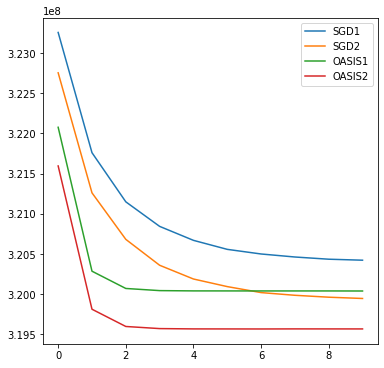

In [333]:
plt.plot(loss_rec1)
plt.plot(loss_rec2)
plt.plot(loss_o1)
plt.plot(loss_o2)
#plt.plot(loss_oa1)
#plt.plot(loss_oa2)
plt.legend(["SGD1", "SGD2", "OASIS1", "OASIS2", "OASIS_a1", "OASIS_a2"])


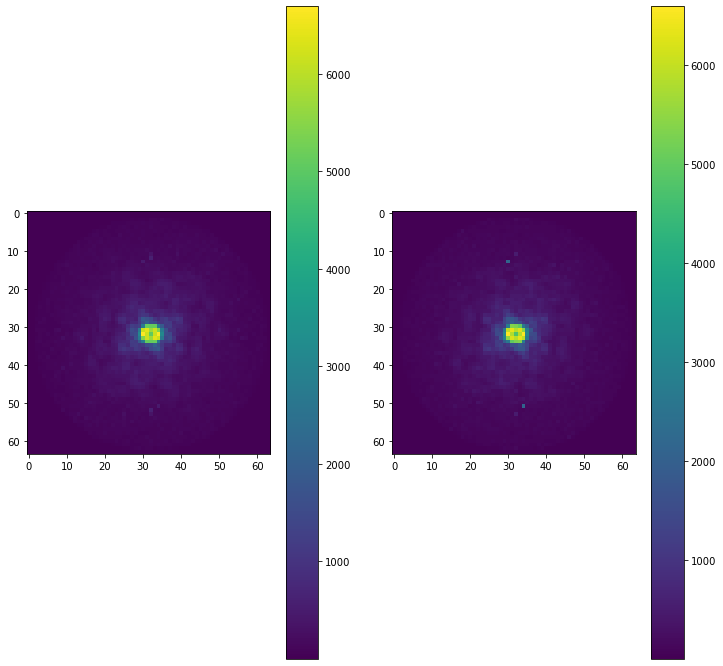

In [334]:
plt.rcParams["figure.figsize"]= 12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec_o1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec_o2))); plt.colorbar()


In [ ]:
#plt.rcParams["figure.figsize"]= 12, 12

#plt.subplot(1,2,1)
#mip_z(np.fft.fftshift(np.real(v_rec_oa1))); plt.colorbar()

#plt.subplot(1,2,2)
#mip_z(np.fft.fftshift(np.abs(v_rec_oa2))); plt.colorbar()


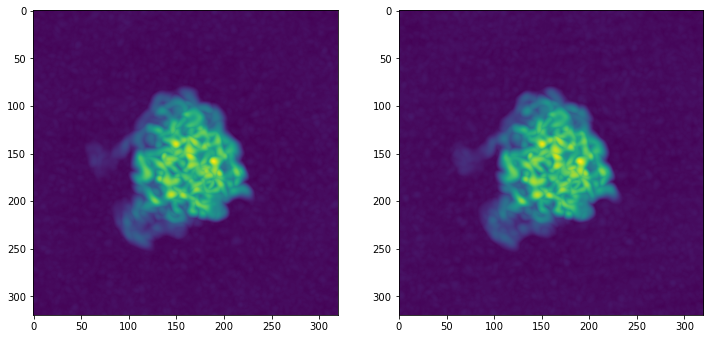

In [335]:
v_rec_ol1, _ = rescale_larger_grid(v_rec_o1, x_grid, nx0)
vr_o1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol1)))

v_rec_ol2, _ = rescale_larger_grid(v_rec_o2, x_grid, nx0)
vr_o2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol2)))

plt.subplot(1,2,1)
mip_z(vr_o1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_o2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [336]:
with mrcfile.new(f"{out_dir}/v_rec_o1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_o2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o2.astype(np.float32))   

Text(0.5, 1.0, 'FSC')

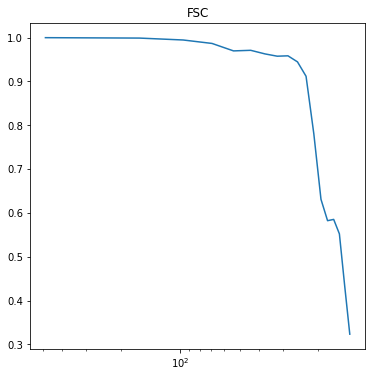

In [337]:
res, fsc_o, shell_points = calc_fsc(v_rec_o1, v_rec_o2, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_o)
plt.gca().invert_xaxis()
plt.title("FSC")

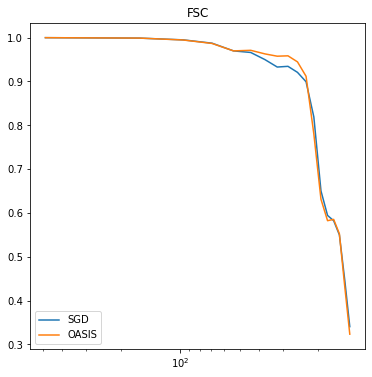

In [338]:
plt.semilogx(res_angs, fsc_sgd)
plt.semilogx(res_angs, fsc_o)
plt.gca().invert_xaxis()
plt.title("FSC")
plt.legend(["SGD", "OASIS"])

In [341]:
print(fsc_o[15])
print(fsc_o[16])
print(res_angs[15])
print(res_angs[16])

0.5522177307152631
0.4322134974937244
15.614531151244588
14.668195929957037


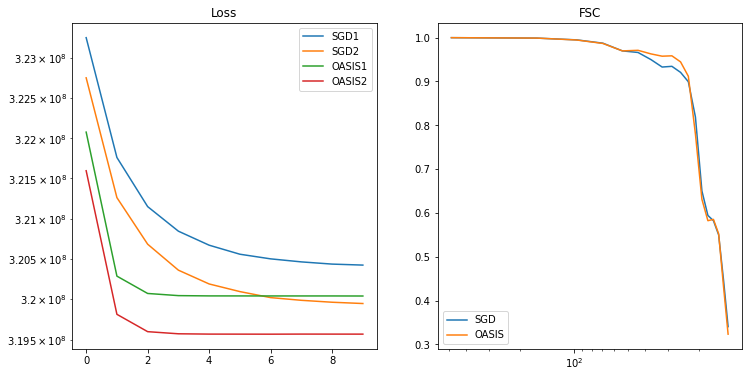

In [342]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)

plt.semilogy(loss_rec1)
plt.semilogy(loss_rec2)
plt.semilogy(loss_o1)
plt.semilogy(loss_o2)
plt.title("Loss")
plt.legend(["SGD1", "SGD2", "OASIS1", "OASIS2"])

plt.subplot(1,2,2)

plt.semilogx(res_angs, fsc_sgd)
plt.semilogx(res_angs, fsc_o)
plt.gca().invert_xaxis()
plt.title("FSC")
plt.legend(["SGD", "OASIS"])

plt.rcParams["figure.figsize"]=6,6

In [ ]:
#loss_func1(v_rec1, jnp.arange(Nn))

In [ ]:
#loss_func2(v_rec2, jnp.arange(Nn))

In [ ]:
#loss_func1(v_rec_o1, jnp.arange(Nn))

In [ ]:
#loss_func2(v_rec_o2, jnp.arange(Nn))

#### Now the same with CG

In [343]:
N_iter = 10


In [344]:
AA1, Ab1 = get_cg_vol_ops(gradv_obj.grad_loss_volume_sum, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], v_rec1.shape, sigma_noise)
AA2, Ab2 = get_cg_vol_ops(gradv_obj.grad_loss_volume_sum, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], v_rec1.shape, sigma_noise)


2022-08-25 14:49:52.118124: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2140] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Failed to allocate request for 237.43GiB (254935041432B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  630.10MiB
              constant allocation:    4.00MiB
        maybe_live_out allocation:    4.00MiB
     preallocated temp allocation:  237.43GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:  238.05GiB
              total fragmentation:    8.00MiB (0.00%)
Peak buffers:
	Buffer 1:
		Size: 58.59GiB
		Operator: op_name="jit(grad_loss_volume_sum)/jit(main)/jit(jvp(loss_sum))/jit(jit_jvp(loss_sum))/jit(jvp(loss_batched))/jit(jit_jvp(loss_batched))/jit(jvp(vmap(loss)))/jit(jit_jvp(vmap(loss)))/jit(jvp(vmap(slice)))/jit(jit_jvp(vmap(slice)))/scatter[update_consts=() dimension_numbers=ScatterDimensionNumbers(update

RuntimeError: RESOURCE_EXHAUSTED: Failed to allocate request for 237.43GiB (254935041432B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  630.10MiB
              constant allocation:    4.00MiB
        maybe_live_out allocation:    4.00MiB
     preallocated temp allocation:  237.43GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:  238.05GiB
              total fragmentation:    8.00MiB (0.00%)
Peak buffers:
	Buffer 1:
		Size: 58.59GiB
		Operator: op_name="jit(grad_loss_volume_sum)/jit(main)/jit(jvp(loss_sum))/jit(jit_jvp(loss_sum))/jit(jvp(loss_batched))/jit(jit_jvp(loss_batched))/jit(jvp(vmap(loss)))/jit(jit_jvp(vmap(loss)))/jit(jvp(vmap(slice)))/jit(jit_jvp(vmap(slice)))/scatter[update_consts=() dimension_numbers=ScatterDimensionNumbers(update_window_dims=(), inserted_window_dims=(0, 1, 2), scatter_dims_to_operand_dims=(0, 1, 2)) indices_are_sorted=True unique_indices=True mode=GatherScatterMode.PROMISE_IN_BOUNDS]" source_file="/gpfs/gibbs/project/lederman/bt387/simple_cryoem/src/interpolate.py" source_line=361
		XLA Label: fusion
		Shape: f64[10000,4096,192]
		==========================

	Buffer 2:
		Size: 58.59GiB
		Operator: op_name="jit(grad_loss_volume_sum)/jit(main)/jit(jvp(loss_sum))/jit(jit_jvp(loss_sum))/jit(jvp(loss_batched))/jit(jit_jvp(loss_batched))/jit(jvp(vmap(loss)))/jit(jit_jvp(vmap(loss)))/jit(jvp(vmap(slice)))/jit(jit_jvp(vmap(slice)))/scatter[update_consts=() dimension_numbers=ScatterDimensionNumbers(update_window_dims=(), inserted_window_dims=(0, 1, 2), scatter_dims_to_operand_dims=(0, 1, 2)) indices_are_sorted=True unique_indices=True mode=GatherScatterMode.PROMISE_IN_BOUNDS]" source_file="/gpfs/gibbs/project/lederman/bt387/simple_cryoem/src/interpolate.py" source_line=361
		XLA Label: fusion
		Shape: f64[10000,4096,192]
		==========================

	Buffer 3:
		Size: 58.59GiB
		Operator: op_name="jit(grad_loss_volume_sum)/jit(main)/jit(jvp(loss_sum))/jit(jit_jvp(loss_sum))/jit(jvp(loss_batched))/jit(jit_jvp(loss_batched))/jit(jvp(vmap(loss)))/jit(jit_jvp(vmap(loss)))/jit(jvp(vmap(slice)))/jit(jit_jvp(vmap(slice)))/scatter[update_consts=() dimension_numbers=ScatterDimensionNumbers(update_window_dims=(), inserted_window_dims=(0, 1, 2), scatter_dims_to_operand_dims=(0, 1, 2)) indices_are_sorted=True unique_indices=True mode=GatherScatterMode.PROMISE_IN_BOUNDS]" source_file="/gpfs/gibbs/project/lederman/bt387/simple_cryoem/src/interpolate.py" source_line=361
		XLA Label: fusion
		Shape: f64[10000,4096,192]
		==========================

	Buffer 4:
		Size: 58.59GiB
		Operator: op_name="jit(grad_loss_volume_sum)/jit(main)/jit(jvp(loss_sum))/jit(jit_jvp(loss_sum))/jit(jvp(loss_batched))/jit(jit_jvp(loss_batched))/jit(jvp(vmap(loss)))/jit(jit_jvp(vmap(loss)))/jit(jvp(vmap(slice)))/jit(jit_jvp(vmap(slice)))/iota[dtype=int64 shape=(10000, 4096, 192) dimension=2]" source_file="/gpfs/gibbs/project/lederman/bt387/simple_cryoem/src/interpolate.py" source_line=361
		XLA Label: fusion
		Shape: s64[192,10000,4096]
		==========================

	Buffer 5:
		Size: 937.50MiB
		XLA Label: custom-call
		Shape: f64[30000,4096]
		==========================

	Buffer 6:
		Size: 625.00MiB
		Entry Parameter Subshape: c128[10000,4096]
		==========================

	Buffer 7:
		Size: 312.50MiB
		Operator: op_name="jit(grad_loss_volume_sum)/jit(main)/jit(jvp(loss_sum))/jit(jit_jvp(loss_sum))/jit(jvp(loss_batched))/jit(jit_jvp(loss_batched))/jit(jvp(vmap(loss)))/jit(jit_jvp(vmap(loss)))/jit(jvp(vmap(slice)))/jit(jit_jvp(vmap(slice)))/reduce[computation=<function _compute_argminmax.<locals>.reducer_fn at 0x2ab3d82fd240> consts=() dimensions=(2,)]" source_file="/gpfs/gibbs/project/lederman/bt387/simple_cryoem/src/interpolate.py" source_line=361
		XLA Label: fusion
		Shape: s64[10000,4096]
		==========================

	Buffer 8:
		Size: 312.50MiB
		Operator: op_name="jit(grad_loss_volume_sum)/jit(main)/jit(jvp(loss_sum))/jit(jit_jvp(loss_sum))/jit(jvp(loss_batched))/jit(jit_jvp(loss_batched))/jit(jvp(vmap(loss)))/jit(jit_jvp(vmap(loss)))/jit(jvp(vmap(slice)))/jit(jit_jvp(vmap(slice)))/reduce[computation=<function _compute_argminmax.<locals>.reducer_fn at 0x2ab3d82fd240> consts=() dimensions=(2,)]" source_file="/gpfs/gibbs/project/lederman/bt387/simple_cryoem/src/interpolate.py" source_line=361
		XLA Label: fusion
		Shape: s64[10000,4096]
		==========================

	Buffer 9:
		Size: 312.50MiB
		Operator: op_name="jit(grad_loss_volume_sum)/jit(main)/jit(jvp(loss_sum))/jit(jit_jvp(loss_sum))/jit(jvp(loss_batched))/jit(jit_jvp(loss_batched))/jit(jvp(vmap(loss)))/jit(jit_jvp(vmap(loss)))/jit(jvp(vmap(slice)))/jit(jit_jvp(vmap(slice)))/reduce[computation=<function _compute_argminmax.<locals>.reducer_fn at 0x2ab3d82fd240> consts=() dimensions=(2,)]" source_file="/gpfs/gibbs/project/lederman/bt387/simple_cryoem/src/interpolate.py" source_line=361
		XLA Label: fusion
		Shape: s64[10000,4096]
		==========================

	Buffer 10:
		Size: 312.50MiB
		Operator: op_name="jit(grad_loss_volume_sum)/jit(main)/jit(jvp(loss_sum))/jit(jit_jvp(loss_sum))/jit(jvp(loss_batched))/jit(jit_jvp(loss_batched))/jit(jvp(vmap(loss)))/jit(jit_jvp(vmap(loss)))/jit(jvp(vmap(slice)))/jit(jit_jvp(vmap(slice)))/reduce[computation=<function _compute_argminmax.<locals>.reducer_fn at 0x2ab3d82fd240> consts=() dimensions=(2,)]" source_file="/gpfs/gibbs/project/lederman/bt387/simple_cryoem/src/interpolate.py" source_line=361
		XLA Label: fusion
		Shape: s64[10000,4096]
		==========================

	Buffer 11:
		Size: 312.50MiB
		Operator: op_name="jit(grad_loss_volume_sum)/jit(main)/jit(jvp(loss_sum))/jit(jit_jvp(loss_sum))/jit(jvp(loss_batched))/jit(jit_jvp(loss_batched))/jit(jvp(vmap(loss)))/jit(jit_jvp(vmap(loss)))/jit(jvp(vmap(slice)))/jit(jit_jvp(vmap(slice)))/reduce[computation=<function _compute_argminmax.<locals>.reducer_fn at 0x2ab3d82fd240> consts=() dimensions=(2,)]" source_file="/gpfs/gibbs/project/lederman/bt387/simple_cryoem/src/interpolate.py" source_line=361
		XLA Label: fusion
		Shape: s64[10000,4096]
		==========================

	Buffer 12:
		Size: 312.50MiB
		Operator: op_name="jit(grad_loss_volume_sum)/jit(main)/jit(jvp(loss_sum))/jit(jit_jvp(loss_sum))/jit(jvp(loss_batched))/jit(jit_jvp(loss_batched))/jit(jvp(vmap(loss)))/jit(jit_jvp(vmap(loss)))/jit(jvp(vmap(slice)))/jit(jit_jvp(vmap(slice)))/reduce[computation=<function _compute_argminmax.<locals>.reducer_fn at 0x2ab3d82fd240> consts=() dimensions=(2,)]" source_file="/gpfs/gibbs/project/lederman/bt387/simple_cryoem/src/interpolate.py" source_line=361
		XLA Label: fusion
		Shape: s64[10000,4096]
		==========================

	Buffer 13:
		Size: 312.50MiB
		Operator: op_name="jit(grad_loss_volume_sum)/jit(main)/jit(jvp(loss_sum))/jit(jit_jvp(loss_sum))/jit(jvp(loss_batched))/jit(jit_jvp(loss_batched))/jit(jvp(vmap(loss)))/jit(jit_jvp(vmap(loss)))/jit(jvp(vmap(slice)))/jit(jit_jvp(vmap(slice)))/reduce[computation=<function _compute_argminmax.<locals>.reducer_fn at 0x2ab3d82fd240> consts=() dimensions=(2,)]" source_file="/gpfs/gibbs/project/lederman/bt387/simple_cryoem/src/interpolate.py" source_line=361
		XLA Label: fusion
		Shape: f64[10000,4096]
		==========================

	Buffer 14:
		Size: 4.00MiB
		Operator: op_name="jit(grad_loss_volume_sum)/jit(main)/jit(jvp(loss_sum))/jit(jit_jvp(loss_sum))/jit(jvp(loss_batched))/jit(jit_jvp(loss_batched))/jit(jvp(vmap(loss)))/jit(jit_jvp(vmap(loss)))/jit(jvp(vmap(slice)))/jit(jit_jvp(vmap(slice)))/convert_element_type[new_dtype=complex128 weak_type=False]" source_file="/gpfs/gibbs/project/lederman/bt387/simple_cryoem/src/jaxops.py" source_line=34
		XLA Label: constant
		Shape: c128[64,64,64]
		==========================

	Buffer 15:
		Size: 4.00MiB
		Entry Parameter Subshape: c128[64,64,64]
		==========================



nction _compute_argminmax.<locals>.reducer_fn at 0x2ab3d82fd240> consts=() dimensions=(2,)]" source_file="/gpfs/gibbs/project/lederman/bt387/simple_cryoem/src/interpolate.py" source_line=361
		XLA Label: fusion
		Shape: s64[10000,4096]

	Buffer 12:
		Size: 312.50MiB
		Operator: op_name="jit(grad_loss_volume_sum)/jit(main)/jit(jvp(loss_sum))/jit(jit_jvp(loss_sum))/jit(jvp(loss_batched))/jit(jit_jvp(loss_batched))/jit(jvp(vmap(loss)))/jit(jit_jvp(vmap(loss)))/jit(jvp(vmap(slice)))/jit(jit_jvp(vmap(slice)))/reduce[computation=<function _compute_argminmax.<locals>.reducer_fn at 0x2ab3d82fd240> consts=() dimensions=(2,)]" source_file="/gpfs/gibbs/project/lederman/bt387/simple_cryoem/src/interpolate.py" source_line=361
		XLA Label: fusion
		Shape: s64[10000,4096]

	Buffer 13:
		Size: 312.50MiB
		Operator: op_name="jit(grad_loss_volume_sum)/jit(main)/jit(jvp(loss_sum))/jit(jit_jvp(loss_sum))/jit(jvp(loss_batched))/jit(jit_jvp(loss_batched))/jit(jvp(vmap(loss)))/jit(jit_jvp(vmap(loss)))/jit(jv

In [ ]:
key, subkey = random.split(key)

v_rec_cg1, k1, v_rec_cg1_all = cg(AA1, Ab1, x01, N_iter, verbose=True)

In [345]:
key, subkey = random.split(key)

v_rec_cg2, k2, v_rec_cg2_all = cg(AA2, Ab2, x02, N_iter, verbose=True)

NameError: name 'AA2' is not defined

In [ ]:
loss_cg1 = jax.vmap(loss_func1, in_axes = (0, None))(jnp.array(v_rec_cg1_all), jnp.arange(N//2))
loss_cg2 = jax.vmap(loss_func2, in_axes = (0, None))(jnp.array(v_rec_cg2_all), jnp.arange(N//2))

In [ ]:
plt.plot(loss_rec1)
plt.plot(loss_rec2)
plt.plot(loss_o1)
plt.plot(loss_o2)
plt.plot(loss_cg1[:20])
plt.plot(loss_cg2[:20])
plt.legend(["SGD1", "SGD2", "OASIS1", "OASIS2", "CG1", "CG2"])


In [ ]:
Nn=N//2

In [ ]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec_cg1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec_cg2))); plt.colorbar()

In [ ]:
v_rec_cgl1, _ = rescale_larger_grid(v_rec_cg1, x_grid, nx0)
vr_cg1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_cgl1)))

v_rec_cgl2, _ = rescale_larger_grid(v_rec_cg2, x_grid, nx0)
vr_cg2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_cgl2)))

plt.subplot(1,2,1)
mip_z(vr_cg1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_cg2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_cg1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_cg1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_cg2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_cg2.astype(np.float32))  

In [ ]:
res, fsc_cg, shell_points = calc_fsc(v_rec_cg1, v_rec_cg2, [1, nx_crop])
#res, fsc_cg, shell_points = calc_fsc(v_rec_cg1, v_rec2, [1, nx_crop])

res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_cg)
plt.gca().invert_xaxis()
plt.title("FSC")

In [ ]:
fsc_cg

In [ ]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)

plt.semilogy(loss_rec1)
plt.semilogy(loss_rec2)
plt.semilogy(loss_o1)
plt.semilogy(loss_o2)
plt.semilogy(loss_cg1[:20])
plt.semilogy(loss_cg2[:20])
plt.title("Loss")
plt.legend(["SGD1", "SGD2", "OASIS1", "OASIS2", "CG1", "CG2"])

plt.subplot(1,2,2)

plt.semilogx(res_angs, fsc_sgd)
plt.semilogx(res_angs, fsc_o)
plt.semilogx(res_angs, fsc_cg)
plt.gca().invert_xaxis()
plt.title("FSC")
plt.legend(["SGD", "OASIS", "CG"])

plt.rcParams["figure.figsize"]=6,6

In [ ]:
print(fsc_cg[11])
print(fsc_cg[12])
print(res_angs[11])
print(res_angs[12])

In [ ]:
print(loss_func1(v_rec1, jnp.arange(Nn)))
print(loss_func1(v_rec_o1, jnp.arange(Nn)))
print(loss_func1(v_rec_cg1, jnp.arange(Nn)))

In [ ]:
print(loss_func2(v_rec2, jnp.arange(Nn)))
print(loss_func2(v_rec_o2, jnp.arange(Nn)))
print(loss_func2(v_rec_cg2, jnp.arange(Nn)))

### Notes:

* It's important to use a large batch size for both SGD and OASIS: 1000 for 64-128px is good.
* OASIS rec with fixed rate is the same as SGD with D0 preconditioner,  the loss and results/FSC are almost identical (since here the Hessian doesn't depend on the current iterate and therefore is estimated perfectly at the beginning). -- actually not true in my latest experiments and I don't know why
* When using no $\sigma_{noise}$ with $128$ pixels and 40,000 images, both OASIS and SGD with precon required higher regularization parameter $10^{-5}$ compared to the other runs, where I used reg param $10^{-9}$
* I should with a dataset with no heterogeneity in the future
* Still don't know why the adaptive version fails

In [ ]:
pixel_size * 320/128

### Results:

Showing resolution cutoff at $FSC=0.5$ everywhere:

#### 1. Small data: `nx_crop=64px` and 10,000 images in each half set, 20 epochs (for SGD/OASIS) and 20 iters (for CG):

Everything here is with regularization parameter $10^{-9}$

Trilinear interpolation
* SGD no precon: $\approx 20 Å$ 
* SGD with precon: $\approx 20 Å$ 
* OASIS: $\approx 20 Å$ 
* OASIS adaptive: meh
* CG: $\approx 20 Å$ 

Nearest neighbour interpolation:

All $\approx 20 Å$ 


^ The FSC curves are almost identical for all

#### 2. Large data: `nx_crop=128px` and 40,000 images in each half set, 10 epochs:

Tri and NN, all around $\approx 14-15 Å$ 

# Figuring out the algorithm, running it on toy problem

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

In [ ]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [ ]:
key, subkey = random.split(key)

A = random.normal(subkey, (n,n), dtype=jnp.complex128)
A = A.T + A

plt.imshow(jnp.real(A)); plt.colorbar()

In [ ]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

#z * A @ z 

In [ ]:
zAz = jax.vmap(lambda zi : zi * (A @ zi))(z)
#plt.imshow(zAz)

In [ ]:
d = np.zeros((iters, n), dtype=A.dtype)
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i-1] + zAz[i]
    
for i in range(1, iters):
    d[i] = d[i]/(i+1)

In [ ]:
err = jnp.mean((d - jnp.diag(A))**2, axis=1)

In [ ]:
plt.semilogy(jnp.abs(err))

#### Hessian-vector product in JaX

In [ ]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [ ]:
b = A @ x0 
f = lambda x : jnp.real(jnp.mean(jnp.conj(A @ x - b)*(A@x-b)))

In [ ]:
from jax import jvp, grad

# Naive
def hvp0(f, x, v):
    return grad(lambda x : jnp.vdot(grad(f)(x), v))(x)

# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [ ]:
%timeit hvp0(f, x, v)

%timeit hvp(f, (x,), (v,))

v1 = hvp0(f, x, v)
v2 = hvp(f, (x,), (v,))
jnp.sum(jnp.abs(v1-v2))

#### Toy problem

In [ ]:
key, *subkey = random.split(key, 3)

x_gt = random.normal(subkey[0], (n,), dtype=jnp.complex128)

A = random.normal(subkey[1], (n,n), dtype=x_gt.dtype)
A = A.T @ A
_, v = jnp.linalg.eigh(A)
d = jnp.flip(jnp.logspace(-5,1,n)) 
d = d + jnp.abs(jnp.min(d)*2)
A = v.T @ jnp.diag(d) @ v

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort(evals))


assert(jnp.sum(evals < 0) == 0)
assert(jnp.max(jnp.imag(evals)) < 1e-13)
#assert(jnp.max(jnp.abs(A.T - A)) == 0)
#assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)

evals = jnp.real(evals)
plt.semilogy(evals, '.')
plt.title("Eigenvalues")
print(f"Condition number = {evals[0]/evals[n-1] : .2e}")

In [ ]:
sig_noise = 1
lam = 0.1

key, subkey = random.split(key)

b = A @ x_gt  + random.normal(subkey, (n,)) * sig_noise

F = jax.jit(lambda x : jnp.real(jnp.mean(jnp.conj(A @ x - b)*(A @ x - b)) + lam * jnp.mean(jnp.conj(x)*x)))
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.jit(jax.grad(F))
#hessianF = jax.hessian(F)

hvpF = jax.jit(lambda x, v : hvp(F, (x,), (v,)))

print(f"gradF(x_gt) = {gradF(x_gt)}")
#print(f"hessianF(x_gt) = {hessianF(x_gt)}")


In [ ]:
def gd(F, gradF, eta, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        w1 = w0 - eta * jnp.conj(gradF(w0))
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

def newton(F, gradF, hessianF, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        G = gradF(w0)
        H = hessianF(w0)
        
        w1 = w0 - jnp.conj(jnp.linalg.inv(H) @ G)
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

In [ ]:
N_iter = 1000
eta = 1e-3 #0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display = 200)

In [ ]:
plt.semilogy(loss_gd)

In [ ]:
#N_iter = 10

#x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

In [ ]:
#plt.plot(loss_n)

In [ ]:
N_iter = 1000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = jax.jit(lambda vv : jnp.conj(gradF(vv)) + Ab)

x_cg, kk, x_cg_all = cg(AA, Ab, x0, N_iter, verbose=True)
loss_cg = jax.vmap(F)(jnp.array(x_cg_all))

In [ ]:
print(F(x_gt))
print(F(x_cg))
print(F(x_gd))
#print(F(x_n))

#### OASIS

In [ ]:
Fidx = jax.jit(lambda x, idx : F(x))
gradFidx = jax.jit(lambda x, idx : jax.grad(F)(x))
hvpFidx = jax.jit(lambda x, v, idx : hvp(F, (x,), (v,)))

In [ ]:
# Estimating D0

iters = 100000
key, *subkeys = random.split(key, iters+1)
zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[i], (n,), dtype=x0.dtype)
    
    zD0z += z * hvpFidx(x0, z, 1)
    
D0 = jnp.array(zD0z/iters)

#D0exact = jnp.diag(hessianF(x0)) # Cheating a bit


In [ ]:
#plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [ ]:
N_iter = 1000
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_iter, iter_display = 100)


In [ ]:
N_iter = 1000
beta2 = 0.99
eta0 = 0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta0, D0, beta2, alpha, N_iter, iter_display = 500)


In [ ]:
#print(jnp.mean(jnp.abs(x_gt-x_n)))
print(jnp.mean(jnp.abs(x_gt-x_cg)))
print(jnp.mean(jnp.abs(x_gt-x_gd)))
print(jnp.mean(jnp.abs(x_gt-x_o)))
print(jnp.mean(jnp.abs(x_gt-x_oa)))

plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)

nn0 = 0
nn1 = 1000
#plt.semilogy(loss_n[nn0:nn1])
plt.semilogy(loss_gd[nn0:nn1])
plt.semilogy(loss_cg[nn0:nn1])
plt.semilogy(loss_o[nn0:nn1])
plt.semilogy(loss_oa[nn0:nn1])
#plt.legend(["Newton", "GD", "OASIS", "OASIS adaptive"])
plt.legend(["GD", "CG", "OASIS", "OASIS adaptive"])
plt.title("Loss")

plt.subplot(1,2,2)
#plt.semilogy(jnp.abs(x_gt-x_n))
plt.semilogy(jnp.abs(x_gt-x_gd))
plt.semilogy(jnp.abs(x_gt-x_o))
plt.semilogy(jnp.abs(x_gt-x_oa))
plt.legend(["GD", "OASIS", "OASIS_adaptive"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6, 6

### Stochastic - sum of operators

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

Generate $N$ operators to create a loss function to run SGD/OASIS on:

In [ ]:
sig_noise = 10
lam = 0.1

In [ ]:
n = 100
N = 1000

key, subkey = random.split(key)

x_gt = random.normal(subkey, (n,), dtype=jnp.complex128)

ops = []
b = []
for i in range(N):
    key, *subkeys = random.split(key, 4)
    
    A = random.normal(subkeys[0], (n,n), dtype = x_gt.dtype)
    A = A.T @ A
    _, v = jnp.linalg.eigh(A)
    
    d = jnp.logspace(10,-5,n) + random.normal(subkeys[1], (n,), dtype = jnp.double)*10 
    d = d + jnp.abs(jnp.min(d)*2)
                 
    A = v.T @ jnp.diag(d) @ v
    ops.append(A)
    
    bn = A @ x_gt + random.normal(subkeys[2], (n,), dtype = x_gt.dtype) * sig_noise
    b.append(bn)
    
    #print(jnp.mean((A@x_gt - bn)**2))
    
ops = jnp.array(ops)
b = jnp.array(b)

In [ ]:
w, _ = jnp.linalg.eigh(A)
w = jnp.flip(jnp.sort(w))
print(f"{jnp.max(w)/jnp.min(w) : .2e}")

In [ ]:
print(jnp.max(w))
print(jnp.min(w))

In [ ]:
def loss_term(x, A, b):
    return 1/2 * jnp.real(jnp.mean(jnp.conj(A@x - b)*(A@x - b)) + lam * jnp.mean(jnp.conj(x)*x))

def loss_func(x, ops, b):
    return jnp.mean(jax.vmap(loss_term, in_axes = (None, 0, 0))(x, ops, b))

def grad_loss_func(x, ops, b):
    return jax.grad(loss_func)(x, ops, b)

def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y : grad_loss_func(y, ops, b), (x,), (v,))[1]

In [ ]:
idx = np.random.permutation(N)[:N//3]

print(loss_term(x_gt, ops[0], b[0]))
print(loss_func(x_gt, ops, b))

print(grad_loss_func(x_gt, ops, b).shape)
print(grad_loss_func(x_gt, ops[idx], b[idx]).shape)

print(hvp_loss_func(x_gt, x_gt, ops, b).shape)
print(hvp_loss_func(x_gt, x_gt, ops[idx], b[idx]).shape)

In [ ]:
key, subkey = random.split(key)

hessianF = lambda x : jax.hessian(loss_func)(x, ops, b)

Fidx = jax.jit(lambda x, idx : loss_func(x, ops[idx], b[idx]))
gradFidx = jax.jit(lambda x, idx : grad_loss_func(x, ops[idx], b[idx]))
hvpFidx = jax.jit(lambda x, v, idx : hvp_loss_func(x, v, ops[idx], b[idx]))
x0 = random.normal(subkey, (n,), dtype = x_gt.dtype)

In [ ]:
Fidx(x_gt, jnp.arange(N))

In [ ]:
#D0 = jnp.ones((nx,nx,nx))  #<--- not very good
#D0exact = jnp.diag(hessianF(x0)) # This is cheating

iters = 10000
batch_sz = 32
key, *subkeys = random.split(key, 2*iters+1)

zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], (n,), dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N)[:batch_sz]
    
    zD0z += z * hvpFidx(x0, z, idx)
    
D0 = jnp.array(zD0z/iters)


#plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_os, loss_os = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 0.01 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_osa, loss_osa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)

In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)


In [ ]:
N_epoch = 20
eta = 1e-18
                       
key, subkey = random.split(key)
x_sgd, loss_sgd, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, verbose = True, iter_display = 1)

In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1
                       
key, subkey = random.split(key)
x_sgdp, loss_sgdp, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, P = 1/D0, verbose = True, iter_display = 1)

In [ ]:
plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)
plt.semilogy(loss_sgd)
plt.semilogy(loss_sgdp)
plt.semilogy(loss_o)
plt.semilogy(loss_os)
plt.semilogy(loss_oa)
plt.semilogy(loss_osa)
plt.legend(["SGD", "SGD precon", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
#plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_sgd-x_gt))
plt.semilogy(jnp.abs(x_sgdp-x_gt))
#plt.semilogy(jnp.abs(x_o-x_gt))
plt.semilogy(jnp.abs(x_os-x_gt))
#plt.semilogy(jnp.abs(x_oa-x_gt))
plt.semilogy(jnp.abs(x_osa-x_gt))
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "SGD+p", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

In [ ]:
plt.semilogy(loss_sgdp)
plt.semilogy(loss_os)
plt.legend(["Loss SGD+precon", "Loss OASIS stochastic"])

In [ ]:
print(Fidx(x_gt, jnp.arange(N)))
print(Fidx(x_sgd, jnp.arange(N)))
print(Fidx(x_sgdp, jnp.arange(N)))
print(Fidx(x_o, jnp.arange(N)))
print(Fidx(x_os, jnp.arange(N)))
print(Fidx(x_oa, jnp.arange(N)))
print(Fidx(x_osa, jnp.arange(N)))


Next:

* ~~Run the new OASIS algorithms on the old (deterministic one operator) toy problem~~
* ~~Implement the adaptive version of the stochastic OASIS~~
* ~~Add noise and rerun all the experiments~~
* In the stochastic toy problem case, also compare with CG (make the problem small enough so that we can do CG)
* ~~Implement some kind of warm up /estimation of $D_0$~~
* ~~Run on CryoEM data~~